# CAS AML Unibe - Module 1 & 2 Project

## Analysis of Cardiovascular Disease

Group:
    
- Asad bin Imtiaz 
- Hop Nguyen
- Marco Kreuzer

## Introduction

In this project we aimed to find a way to predict the Cardiovascular Disease (CVD) using medical and demographoic features from around 70,000 patients. Cardiovascular disease (CVD) is a general term for conditions diseases that affect heart and blood vessels. CVD is a leading cause of death and disability in Swizerland and around the world, but a large part of can be prevented by maintaining a healthy lifestyle.

According to the latest WHO data published in 2020 Coronary Heart Disease Deaths in Switzerland reached 10,713 or 18.49% of total deaths. The age adjusted Death Rate is 41.51 per 100,000 of population ranks Switzerland #170 in the world. Cardiovascular disease and cancer are two of most widespread causes of death in Switzerland. 

Several machine learning (ML) algorithms are increasingly being used to predict cardiovascular disease. We attempted here to build ML models to pridict the disease using a few common demographical and medical features with high accuracy. We employed several Unsumervised and Supervise approaches to predict the disease with high accuracy

## Dataset

This dataset is openly accessible and was downloaded from Kaggle. 

The link to data is: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

There are 3 types of input features:

Objective  : Factual & demographic information
Examination: Results of medical examination
Subjective : Information provided by the patient

Following features are available in the data.

|Feature Name |Kind |Header|DataType|
|:-|:-|:-|:-|
|Age | Objective Feature | age | int (days) |
|Height | Objective Feature | height | int (cm) |
|Weight | Objective Feature | weight | float (kg) |
|Gender | Objective Feature | gender | categorical code |
|Systolic blood pressure | Examination Feature | ap_hi | int |
|Diastolic blood pressure | Examination Feature | ap_lo | int |
|Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
|Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
|Smoking | Subjective Feature | smoke | binary |
|Alcohol intake | Subjective Feature | alco | binary |
|Physical activity | Subjective Feature | active | binary |
|Presence or absence of CVD |**Target Variable**| cardio | binary |

## Setup

Following Python libraries are installed and imported

* pip install pandas
* pip install numpy
* pip install opendatasets
* pip install matplotlib
* pip install seaborn
* pip install sklearn

In [2]:
import pandas as pd
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_predict
from sklearn.preprocessing import StandardScaler

### Download the dataset

You can create a Kaggle API token from your Kaggle account and put this file in .kaggle directory your home directory. 
Alternately you may iser Kaggle API command

kaggle datasets download -d sulianova/cardiovascular-disease-dataset

In [3]:
#od.download("https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset")

## Load data in Pandas

Lets load the data in a Pandas dataframe and have a first look

In [4]:
#df = pd.read_csv('cardiovascular-disease-dataset/cardio_train.csv',sep=";")
df = pd.read_csv('cardio_train.csv',sep=";")
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Lets have a closer look at the dataset. Starting with inferred datatypes:

In [5]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

The id is not really user. Lets convert it to a string.

In [6]:
df.id.astype('string')

0            0
1            1
2            2
3            3
4            4
         ...  
69995    99993
69996    99995
69997    99996
69998    99998
69999    99999
Name: id, Length: 70000, dtype: string

The age is in days, lets convert it into years.

### Feature enhancement and Cleansing

In [7]:
df_feature = df.copy()
df_feature.age = ((df_feature.age/365))
#df_feature.age = df_feature.age.astype('int')
df_feature.head(2)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1


The id is not really a feature. Let us get rid of it.

In [8]:
df_feature = df_feature.drop(['id'],axis=1)

Lets see if there are any duplicates in the data and get rid of them.

In [9]:
df_feature.duplicated().sum()

24

In [10]:
df_feature.drop_duplicates(inplace=True)

The gender values are 1 or 2 but we do not know if 1 means male or female. Generally females are shorter than male. Also they are lighter than males. Lets try to figure out the gender based on these assumptions.

In [11]:
df[['gender','height','weight']].groupby('gender').mean()

,height,weight
gender,,
1,161.355612,72.565605
2,169.947895,77.257307


So 1 in gender means Female and 2 is Make. Lets make this feature catagorical where category 0 is Male and 1 is Female.

In [12]:
df_feature.gender = df.gender.map({1: 'F', 2: 'M'}).astype('category')

gender_map = dict([ (v,k) for k,v in  enumerate(df_feature.gender.cat.categories )])
print(gender_map)

df_feature.head(2)

{'F': 0, 'M': 1}


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,M,168,62.0,110,80,1,1,0,0,1,0
1,55.419178,F,156,85.0,140,90,3,1,0,0,1,1


Similarly cholestrol and glucose features are also categorical. Lets convert them to categorical type as well.

In [13]:
df_feature.cholesterol = df.cholesterol.map({1: 'Normal', 2: 'Above Normal', 3: 'High'}).astype('category')

cholesterol_map = dict([ (v,k) for k,v in  enumerate(df_feature.cholesterol.cat.categories )])
print(cholesterol_map)

df_feature.head(2)

{'Above Normal': 0, 'High': 1, 'Normal': 2}


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,M,168,62.0,110,80,Normal,1,0,0,1,0
1,55.419178,F,156,85.0,140,90,High,1,0,0,1,1


In [14]:
df_feature.gluc = df.gluc.map({1: 'Normal', 2: 'Above Normal', 3: 'High'}).astype('category')

gluc_map = dict([ (v,k) for k,v in  enumerate(df_feature.gluc.cat.categories )])
print(gluc_map)

df_feature.head(2)

{'Above Normal': 0, 'High': 1, 'Normal': 2}


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,M,168,62.0,110,80,Normal,Normal,0,0,1,0
1,55.419178,F,156,85.0,140,90,High,Normal,0,0,1,1


Lets find if there are some gaps or missing values in the dataframe.

In [15]:
df_feature.isnull().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

Lest see how weight and height for each gender is distributed on a scatter plot.

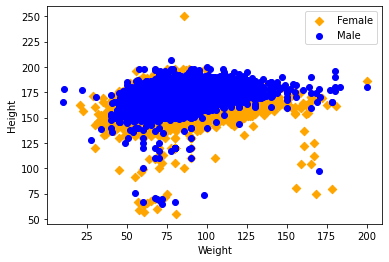

In [16]:
plt.scatter(df['weight'][(df.gender == 1)], df['height'][(df.gender == 1)], marker='D', color='orange', label='Female')
plt.scatter(df['weight'][(df.gender == 2)], df['height'][(df.gender == 2)], marker='o', color='blue'  , label='Male')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend()
plt.show()

It looks like there may be some outliers in height and weight for males and females. Lets replace by their respective average values.

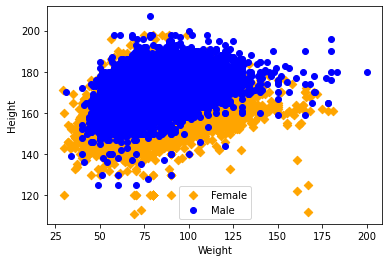

In [17]:
df_feature.loc[((df['height']>= 210) | (df['height']<= 110)) & (df['gender']==1),'height'] = round(df[((df['height']< 210) | (df['height']> 110)) & (df['gender']==1)].height.mean())
df_feature.loc[((df['height']>= 220) | (df['height']<= 120)) & (df['gender']==2),'height'] = round(df[((df['height']< 220) | (df['height']> 120)) & (df['gender']==2)].height.mean())
df_feature.loc[((df['weight']>= 200) | (df['weight']<= 25))  & (df['gender']==1),'weight'] = round(df[((df['weight']< 200) | (df['weight']> 25))  & (df['gender']==1)].weight.mean())
df_feature.loc[((df['weight']>= 215) | (df['weight']<= 30))  & (df['gender']==2),'weight'] = round(df[((df['weight']< 215) | (df['weight']> 30))  & (df['gender']==2)].weight.mean())

plt.scatter(df_feature['weight'][(df_feature.gender == 'F')], df_feature['height'][(df_feature.gender == 'F')], marker='D', color='orange', label='Female')
plt.scatter(df_feature['weight'][(df_feature.gender == 'M')], df_feature['height'][(df_feature.gender == 'M')], marker='o', color='blue'  , label='Male')
plt.xlabel('Weight')
plt.ylabel('Height')
plt.legend()
plt.show()

It looks like dataset is now cleaned. Lest have a look at the data distributions.

In [18]:
df_feature.describe()

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,53.339589,164.422216,74.211548,128.820453,96.636261,0.088159,0.053790,0.803718,0.499771
std,6.759930,7.905990,14.380217,154.037729,188.504581,0.283528,0.225604,0.397187,0.500004
min,29.583562,111.000000,29.000000,-150.000000,-70.000000,0.000000,0.000000,0.000000,0.000000
25%,48.394521,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
50%,53.980822,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
75%,58.430137,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000
max,64.967123,207.000000,200.000000,16020.000000,11000.000000,1.000000,1.000000,1.000000,1.000000


It looks like some numerical values like BP are negative or too high or low. A plausible range for ap_hi may be (40-250) and for ap_lo may be (30-180). We need to clean these values. There may be multiple ways to fix them.

1. Remove the records with these values
2. Replace them with normal medical values (ap_hi : Systolic Normal = 120, ap_lo : Diastolic Normal = 80)
3. Replace them with average values of their genders

Note we do not consider target values to fill in these unplausible values. That would be cheating.

In [19]:
n_ap_hi = round(df[((df['ap_hi']>= 60) & (df['ap_hi']<= 240) & (df['ap_lo']>= 30) & (df['ap_lo']<= 180) & (df['ap_hi']>df['ap_lo']))].ap_hi.mean())
n_ap_lo = round(df[((df['ap_hi']>= 60) & (df['ap_hi']<= 240) & (df['ap_lo']>= 30) & (df['ap_lo']<= 180) & (df['ap_hi']>df['ap_lo']))].ap_lo.mean())

df_feature.loc[((df['ap_hi']< 60) | (df['ap_hi']> 240) | (df['ap_lo']< 30) | (df['ap_lo']> 180) | (df['ap_hi']<=df['ap_lo'])),'ap_hi'] = n_ap_hi
df_feature.loc[((df['ap_lo']< 30) | (df['ap_lo']> 180) | (df['ap_lo']< 30) | (df['ap_lo']> 180) | (df['ap_hi']<=df['ap_lo'])),'ap_lo'] = n_ap_lo

In [20]:
df_feature.describe()

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,53.339589,164.422216,74.211548,126.682162,81.296130,0.088159,0.053790,0.803718,0.499771
std,6.759930,7.905990,14.380217,16.536783,9.373928,0.283528,0.225604,0.397187,0.500004
min,29.583562,111.000000,29.000000,60.000000,30.000000,0.000000,0.000000,0.000000,0.000000
25%,48.394521,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
50%,53.980822,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000
75%,58.430137,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000
max,64.967123,207.000000,200.000000,240.000000,180.000000,1.000000,1.000000,1.000000,1.000000


Lets calculate Body-Mass-Index (BMI) which is a measurement of a person's leanness or corpulence based on their height and weight. The World Health Organization's (WHO) recommended body weight based on BMI values for adults are:

|Category|BMI range - kg/m2|
|-|-|
|Severe Thinness|	< 16|
|Moderate Thinness|	16 - 17|
|Mild Thinness|	17 - 18.5|
|Normal|	18.5 - 25|
|Overweight|	25 - 30|
|Obese Class I|	30 - 35|
|Obese Class II|	35 - 40|
|Obese Class III|	> 40|

The calculation for BMI is as follows:

**BMI** = (Weight in KG)/ ((Height in Meters)^2)

We have wright in KG and height in centi meters. Lets calculate BMI. 

Note there is insignificant difference in BMI for male and female so we assign the same calculation to both. Since all data is for adults, no specific calculation of young adults or children is needed.

In [21]:
df_feature['bmi']= df.weight/(df.height/100)**2 #round((df.weight/(df.height/100)**2)*2)/2

lets categorize BMI.

In [22]:
df_feature.loc[(df_feature.bmi < 16), 'bmi_cat'] = 'Severe Thinness'
df_feature.loc[(df_feature.bmi < 18.5) & (df_feature.bmi >= 16), 'bmi_cat'] = 'Mild Thinness'
df_feature.loc[(df_feature.bmi < 25)   & (df_feature.bmi >= 18.5), 'bmi_cat'] = 'Normal'
df_feature.loc[(df_feature.bmi < 30)   & (df_feature.bmi >= 25), 'bmi_cat'] = 'Overweight'
df_feature.loc[(df_feature.bmi >= 30), 'bmi_cat'] = 'Obese'

df_feature.bmi_cat = df_feature.bmi_cat.astype('category')

In [23]:
bmi_map = dict([ (v,k) for k,v in  enumerate(df_feature.bmi_cat.cat.categories)])
print(bmi_map)

df_feature.head(2)

{'Mild Thinness': 0, 'Normal': 1, 'Obese': 2, 'Overweight': 3, 'Severe Thinness': 4}


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmi_cat
0,50.391781,M,168,62.0,110,80,Normal,Normal,0,0,1,0,21.967120,Normal
1,55.419178,F,156,85.0,140,90,High,Normal,0,0,1,1,34.927679,Obese


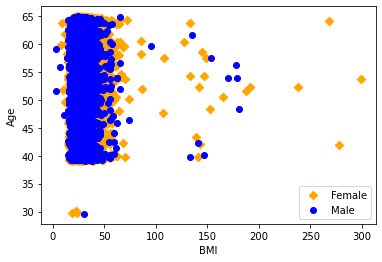

In [24]:
plt.scatter(df_feature['bmi'][(df_feature.gender == 'F')], df_feature['age'][(df_feature.gender == 'F')], marker='D', color='orange', label='Female')
plt.scatter(df_feature['bmi'][(df_feature.gender == 'M')], df_feature['age'][(df_feature.gender == 'M')], marker='o', color='blue', label='Male')
plt.xlabel('BMI')
plt.ylabel('Age')
plt.legend()
plt.show()

Looks like there are outliers in BMI. Let remove them by replacing them with mean of that gender

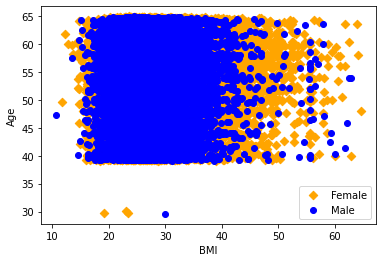

In [25]:
f_bmi = round(df_feature[((df_feature['bmi']<= 65) & (df_feature['bmi']>= 10) & (df_feature['gender']== 'F'))].bmi.mean())
m_bmi = round(df_feature[((df_feature['bmi']<= 65) & (df_feature['bmi']>= 10) & (df_feature['gender']== 'M'))].bmi.mean())

df_feature.loc[((df_feature['bmi']>  65) | (df_feature['bmi']< 10)) & (df_feature['gender']== 'F'),'bmi']= f_bmi
df_feature.loc[((df_feature['bmi']>  65) | (df_feature['bmi']< 10)) & (df_feature['gender']== 'M'),'bmi']= m_bmi
               
plt.scatter(df_feature['bmi'][(df_feature.gender == 'F')], df_feature['age'][(df_feature.gender == 'F')], marker='D', color='orange', label='Female')
plt.scatter(df_feature['bmi'][(df_feature.gender == 'M')], df_feature['age'][(df_feature.gender == 'M')], marker='o', color='blue', label='Male')
plt.xlabel('BMI')
plt.ylabel('Age')
plt.legend()
plt.show()

Also get rid of outliers in age

In [26]:
df_feature = df_feature[df_feature['age']>=35]

Lets look at the distributions again

In [27]:
df_feature.describe()

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,bmi
count,69972.000000,69972.000000,69972.000000,69972.000000,69972.000000,69972.000000,69972.000000,69972.000000,69972.000000,69972.000000
mean,53.340935,164.422055,74.211946,126.682973,81.296633,0.088164,0.053793,0.803707,0.499800,27.490107
std,6.757779,7.905969,14.380126,16.536789,9.373750,0.283535,0.225610,0.397195,0.500004,5.257588
min,39.109589,111.000000,29.000000,60.000000,30.000000,0.000000,0.000000,0.000000,0.000000,10.726644
25%,48.397260,159.000000,65.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,53.980822,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,1.000000,0.000000,26.395803
75%,58.430137,170.000000,82.000000,140.000000,90.000000,0.000000,0.000000,1.000000,1.000000,30.178450
max,64.967123,207.000000,200.000000,240.000000,180.000000,1.000000,1.000000,1.000000,1.000000,64.516129


In [28]:
df_feature.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi,bmi_cat
0,50.391781,M,168,62.0,110,80,Normal,Normal,0,0,1,0,21.967120,Normal
1,55.419178,F,156,85.0,140,90,High,Normal,0,0,1,1,34.927679,Obese
2,51.663014,F,165,64.0,130,70,High,Normal,0,0,0,1,23.507805,Normal
3,48.282192,M,169,82.0,150,100,Normal,Normal,0,0,1,1,28.710479,Overweight
4,47.873973,F,156,56.0,100,60,Normal,Normal,0,0,0,0,23.011177,Normal


## Explore & Visualize data

Lets first look at the target class imbalance.

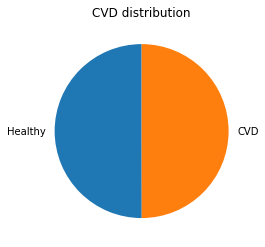

In [29]:
labels = df_feature.cardio.unique()
plt.pie([(df_feature.cardio == labels[0]).sum(),(df_feature.cardio == labels[1]).sum()], labels = ['Healthy','CVD'], startangle = 90)
plt.title("CVD distribution")
plt.show()

Looks like target class is relatively balanced.

Lets visualize the data gender wise. We would first take the numerical/binary data w.r.t gender.

Lets first see the gender distribution in data.

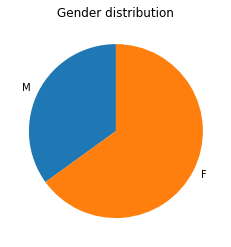

In [30]:
labels = df_feature.gender.unique()
plt.pie([(df_feature.gender == labels[0]).sum(),(df_feature.gender == labels[1]).sum()], labels = labels, startangle = 90)
plt.title("Gender distribution")
plt.show()

Looks like we have around 50% more females in data than males

Lets see distribution with respect to class.

<AxesSubplot:xlabel='gender'>

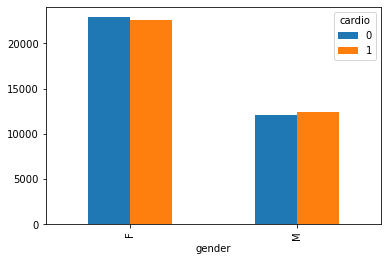

In [31]:
pd.crosstab(df_feature.gender,df_feature.cardio).plot(kind='bar')

Lets look at class distribution of cholestrol

<AxesSubplot:xlabel='cholesterol'>

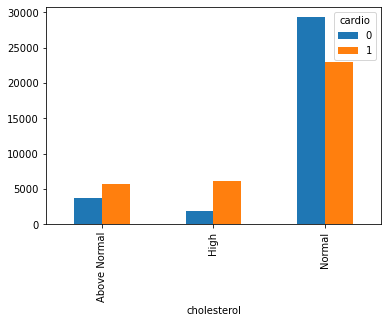

In [32]:
pd.crosstab(df_feature.cholesterol,df_feature.cardio).plot(kind='bar')

<AxesSubplot:xlabel='gluc'>

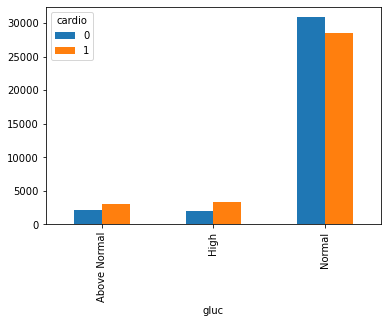

In [33]:
pd.crosstab(df_feature.gluc,df_feature.cardio).plot(kind='bar')

#### Scatter Matrix

In multivariate statistics and probability theory, the scatter matrix is a statistic that is used to make estimates of the covariance matrix, for instance of the multivariate normal distribution. Lets draw a scatter matrix to see corelations among the numeric features.

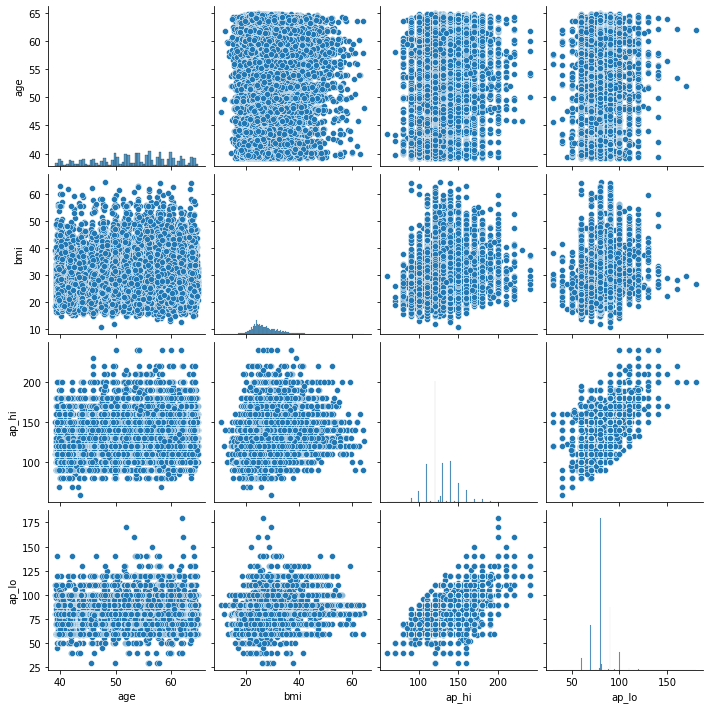

In [34]:
# Basic correlogram demographics
sns.pairplot(df_feature[['age','bmi','ap_hi','ap_lo']])
plt.show()

Looks like some corelation may exist. Lets draw a corelation values from the scatter matrix.

In [35]:
corr = df.corr()
#corr = corr.where(np.tril(np.ones(corr.shape)).astype(bool))
#(corr.style
# .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
# .format(precision=2)
# .highlight_null(null_color='#f1f1f1')
# )
corr = corr.where(np.tril(np.ones(corr.shape)).astype(bool))
(corr.style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')
 )

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
age,0.003457,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
gender,0.003502,-0.022811,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
height,-0.003038,-0.081515,0.499033,1.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan
weight,-0.001830,0.053684,0.155406,0.290968,1.000000,nan,nan,nan,nan,nan,nan,nan,nan
ap_hi,0.003356,0.020764,0.006005,0.005488,0.030702,1.000000,nan,nan,nan,nan,nan,nan,nan
ap_lo,-0.002529,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,nan,nan,nan,nan,nan,nan
cholesterol,0.006106,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,nan,nan,nan,nan,nan
gluc,0.002467,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,nan,nan,nan,nan
smoke,-0.003699,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,nan,nan,nan


It looks like subjective features 'Smoke','Phisically active' & 'Drink alcohol', whiuch most probably came from patient themselves have minimum corelation to target. Lets get rid on them.

In [36]:
df_cleaned = df_feature.drop(['smoke','alco','active'],axis=1)
df_cleaned

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,cardio,bmi,bmi_cat
0,50.391781,M,168,62.0,110,80,Normal,Normal,0,21.967120,Normal
1,55.419178,F,156,85.0,140,90,High,Normal,1,34.927679,Obese
2,51.663014,F,165,64.0,130,70,High,Normal,1,23.507805,Normal
3,48.282192,M,169,82.0,150,100,Normal,Normal,1,28.710479,Overweight
4,47.873973,F,156,56.0,100,60,Normal,Normal,0,23.011177,Normal
...,...,...,...,...,...,...,...,...,...,...,...
69995,52.712329,M,168,76.0,120,80,Normal,Normal,0,26.927438,Overweight
69996,61.920548,F,158,126.0,140,90,Above Normal,Above Normal,1,50.472681,Obese
69997,52.235616,M,183,105.0,180,90,High,Normal,1,31.353579,Obese
69998,61.454795,F,163,72.0,135,80,Normal,Above Normal,1,27.099251,Overweight


We use the cleansed dataframe for further ML tasks.

## Machine Learning

In [37]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score,accuracy_score,classification_report

Delete the target label. split bin X, y sets for features and target.

In [38]:
X = df_cleaned.drop(['cardio','bmi_cat','height','weight'],axis=1)
y = df_cleaned['cardio'].copy()

X.gender = X.gender.map(gender_map)
X.cholesterol = X.cholesterol.map(cholesterol_map)
X.gluc = X.gluc.map(gluc_map)

X.head(2)

,age,gender,ap_hi,ap_lo,cholesterol,gluc,bmi
0,50.391781,1,110,80,2,2,21.967120
1,55.419178,0,140,90,1,2,34.927679


### Train Test Split

Split the data into a training set and a test set. Since the data is not huge, we split 90 to 10. 

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)

### Feature Normalization

Lets normalize the numerical values to same ranges.Lets normalize the numerical values to same ranges.

In [40]:
scaler = StandardScaler()

X_train[['age','ap_hi','ap_lo','bmi']] = scaler.fit_transform(X_train[['age','ap_hi','ap_lo','bmi']])
X_train.head(5)

,age,gender,ap_hi,ap_lo,cholesterol,gluc,bmi
66590,-1.309825,1,-0.405771,-0.140358,0,2,1.203272
51432,-0.478279,1,0.805417,0.926138,2,2,-0.399091
8978,0.375971,0,2.924995,0.392890,2,2,4.837037
69162,1.291442,1,0.018145,-0.033708,2,2,2.047125
14788,0.931011,1,-0.405771,-0.140358,0,2,0.292821


In [41]:
X_test[['age','ap_hi','ap_lo','bmi']] = scaler.transform(X_test[['age','ap_hi','ap_lo','bmi']])
X_test.head(5)

,age,gender,ap_hi,ap_lo,cholesterol,gluc,bmi
55738,0.129873,1,0.805417,0.926138,0,2,0.422686
2600,-1.906624,0,-1.011365,-0.140358,2,2,-1.360902
59232,-1.098593,0,-1.011365,-1.206854,2,2,-0.419597
16021,1.069264,1,0.018145,-0.033708,2,2,1.371485
62881,-1.404291,0,-0.405771,0.926138,2,2,-0.217699


## Unsupervised Learning

- PCA
- Kmeans
- Hierarichal clustering

## PCA

Prepare Save fig and PCA

In [42]:
import os
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [43]:
from sklearn.decomposition import PCA

Check again Train Set

In [44]:
X_train.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,bmi
66590,-1.309825,1,-0.405771,-0.140358,0,2,1.203272
51432,-0.478279,1,0.805417,0.926138,2,2,-0.399091
8978,0.375971,0,2.924995,0.392890,2,2,4.837037
69162,1.291442,1,0.018145,-0.033708,2,2,2.047125
14788,0.931011,1,-0.405771,-0.140358,0,2,0.292821


Lets Fit with PCA

In [45]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

Take a look on dimensions

In [46]:
pca.n_components_

7

Percentage of Variance explained by each of the sel. Components

In [47]:
pca.explained_variance_ratio_

array([0.39324694, 0.18255107, 0.17242523, 0.10543114, 0.05191155,
       0.0509345 , 0.04349957])

cumsum would be 1 if not n_components

In [48]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum >= 0.95

array([False, False, False, False, False,  True,  True])

Check dimensions for Variance ratio 95%

In [49]:
d = np.argmax(cumsum >= 0.95) + 1
d

6

Look for the "Elbow"

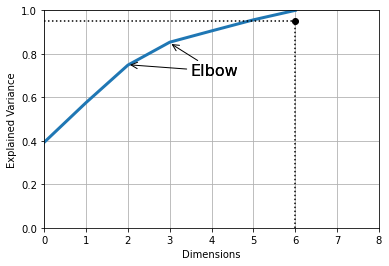

In [50]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 8, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(3, 0.85), xytext=(3.5, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.annotate("Elbow", xy=(2, 0.75), xytext=(3.5, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

Check with 3 Components

In [51]:
pca2 = PCA(n_components = 2)
pca2.fit(X_train)

PCA(n_components=2)

In [52]:
cumsum = np.cumsum(pca2.explained_variance_ratio_)
cumsum

array([0.39324694, 0.57579801])

In [53]:
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
X_reduced2 = pca2.fit_transform(X_train)
X_recovered2 = pca2.inverse_transform(X_reduced2)


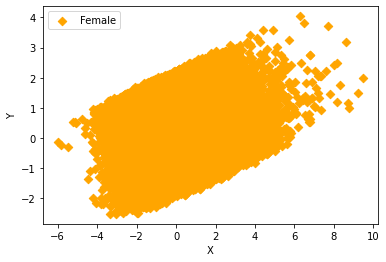

In [54]:
plt.scatter(X_reduced2[:,0],X_reduced2[:,1], marker='D', color='orange', label='Female')

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

### Kernel PCA

In [55]:
from sklearn.decomposition import KernelPCA


k = 2
rbf_pca = KernelPCA(n_components = k, kernel="rbf", gamma=0.04, fit_inverse_transform=True)
X_reduced_kpca = rbf_pca.fit_transform(X_test)

lin_pca = KernelPCA(n_components = k, kernel="linear", fit_inverse_transform=True)
X_reduced_linkpca = lin_pca.fit_transform(X_test)

sig_pca = KernelPCA(n_components = k, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)
X_reduced_sigpca = lin_pca.fit_transform(X_test)


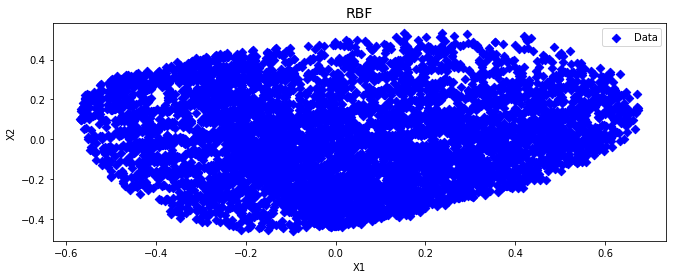

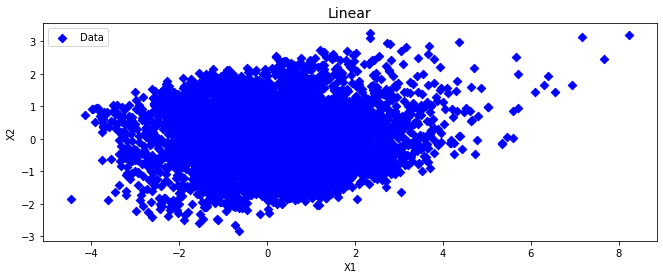

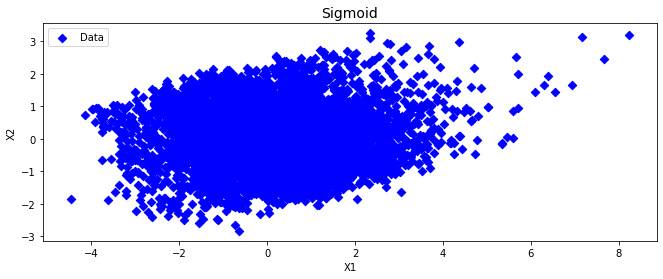

In [56]:
plt.figure(figsize=(11,4))
plt.title('RBF', fontsize=14)
plt.scatter(X_reduced_kpca[:,0],X_reduced_kpca[:,1], marker='D', color='blue',label='Data')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

plt.figure(figsize=(11,4))
plt.title('Linear', fontsize=14)
plt.scatter(X_reduced_linkpca[:,0],X_reduced_linkpca[:,1], marker='D', color='blue',label='Data')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

plt.figure(figsize=(11,4))
plt.title('Sigmoid', fontsize=14)
plt.scatter(X_reduced_linkpca[:,0],X_reduced_linkpca[:,1], marker='D', color='blue',label='Data')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

In [57]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced_lle = lle.fit_transform(X_test)


#from sklearn.manifold import MDS
#mds = MDS(n_components=2, random_state=42)
#X_reduced_mds = mds.fit_transform(X_test)


from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_test)

#from sklearn.manifold import TSNE
#tsne = TSNE(n_components=2, random_state=42)
#X_reduced_tsne = tsne.fit_transform(X_test)



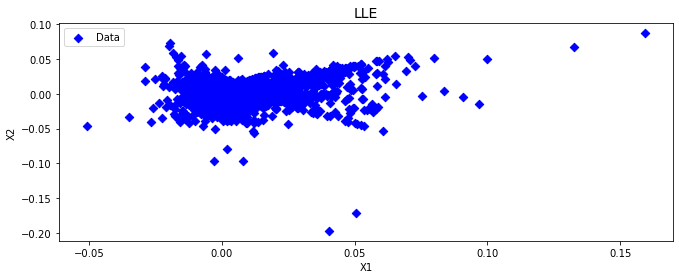

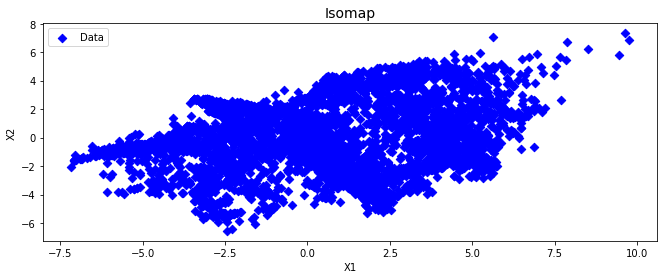

In [58]:
plt.figure(figsize=(11,4))
plt.title('LLE', fontsize=14)
plt.scatter(X_reduced_lle[:,0],X_reduced_lle[:,1], marker='D', color='blue',label='Data')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

#plt.figure(figsize=(11,4))
#plt.title('MDS', fontsize=14)
#plt.scatter(X_reduced_mds[:,0],X_reduced_mds[:,1], marker='D', color='blue',label='Data')

#plt.xlabel('X1')
#plt.ylabel('X2')
#plt.legend()
#plt.show()

plt.figure(figsize=(11,4))
plt.title('Isomap', fontsize=14)
plt.scatter(X_reduced_isomap[:,0],X_reduced_isomap[:,1], marker='D', color='blue',label='Data')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

#plt.figure(figsize=(11,4))
#plt.title('TSNE', fontsize=14)
#plt.scatter(X_reduced_tsne[:,0],X_reduced_tsne[:,1], marker='D', color='blue',label='Data')

#plt.xlabel('X1')
#plt.ylabel('X2')
#plt.legend()
#plt.show()

## K-Means

Check again Training set

In [59]:
X_train.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,bmi
66590,-1.309825,1,-0.405771,-0.140358,0,2,1.203272
51432,-0.478279,1,0.805417,0.926138,2,2,-0.399091
8978,0.375971,0,2.924995,0.392890,2,2,4.837037
69162,1.291442,1,0.018145,-0.033708,2,2,2.047125
14788,0.931011,1,-0.405771,-0.140358,0,2,0.292821


In [60]:
from sklearn.cluster import KMeans

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced2)

Check how instances are assigned

In [61]:
y_pred

array([0, 1, 1, ..., 1, 1, 0], dtype=int32)

In [62]:
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1)) #max count is 0, so everytime max count is assigned 0, min to 2
lut = np.zeros_like(idx) 
lut[idx] = np.arange(k) 
y_kmeans = lut[y_pred] 

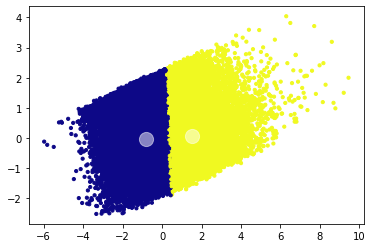

In [63]:
plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=y_kmeans, s=10, cmap='plasma')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=200, alpha=0.5)

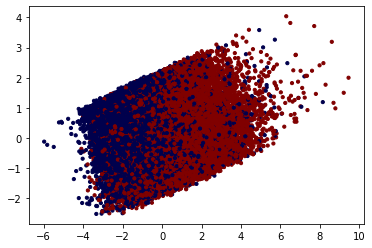

In [64]:
# Actual Clusters
plt.scatter(X_reduced2[:, 0], X_reduced2[:, 1], c=y_train, s=10, cmap='seismic')


In [65]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_kmeans)

0.6961920792708102

In [66]:
from sklearn.cluster import KMeans

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_train)
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1)) #max count is 0, so everytime max count is assigned 0, min to 2
lut = np.zeros_like(idx) 
lut[idx] = np.arange(k) 
y_kmeans = lut[y_pred] 

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_kmeans)

0.6972083717089592

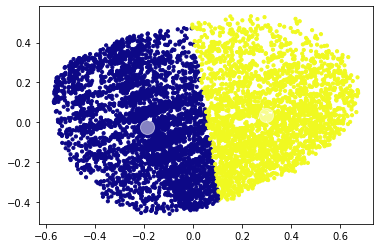

In [68]:
from sklearn.cluster import KMeans

k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced_kpca)
idx = np.argsort(kmeans.cluster_centers_.sum(axis=1)) #max count is 0, so everytime max count is assigned 0, min to 2
lut = np.zeros_like(idx) 
lut[idx] = np.arange(k) 
y_kmeans = lut[y_pred] 
plt.scatter(X_reduced_kpca[:, 0], X_reduced_kpca[:, 1], c=y_kmeans, s=10, cmap='plasma')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='white', s=200, alpha=0.5)

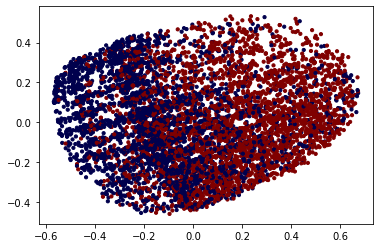

In [69]:
plt.scatter(X_reduced_kpca[:, 0], X_reduced_kpca[:, 1], c=y_test, s=10, cmap='seismic')

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_kmeans)

0.7064875678765361

See the Centroids

In [71]:
kmeans.cluster_centers_

array([[-0.18718587, -0.02346829],
       [ 0.2990527 ,  0.03749352]])

Indexes of clusters, same as datapoint are assigned to indexes

In [72]:
kmeans.labels_

array([1, 0, 0, ..., 1, 1, 0], dtype=int32)

No predict how an arbitrary Dataset would cluster

In [73]:
#X_new = np.array(
#    [[1, 1, -0.5, -0.6, 2, 1,-0.8], 
#     [1.2, 0, -0.1, -0.3, 1, 1,-0.1], 
#     [0.2, 0, 2, 1, 1, 2,-0.4], 
#     [-0.1, 1, 1, 0.6, 2, 1,-0.6]])

#X_new

X_new = np.array(
    [[-0.6,-0.8], 
     [-0.1,-0.1], 
     [0.2,-0.4], 
     [-0.1, -0.6]])

X_new




array([[-0.6, -0.8],
       [-0.1, -0.1],
       [ 0.2, -0.4],
       [-0.1, -0.6]])

In [74]:
kmeans.predict(X_new)

array([0, 0, 1, 0], dtype=int32)

### K-Means Algorithm

Lets See how random centroids effect the clustering

In [75]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X_train)
kmeans_iter2.fit(X_train)
kmeans_iter3.fit(X_train)

/home/mk/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1316: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/home/mk/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1316: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(
/home/mk/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1316: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

In [76]:
kmeans_iter1.labels_

array([2, 1, 2, ..., 1, 1, 0], dtype=int32)

Lets see how the clustering looks like for 100 datapoints

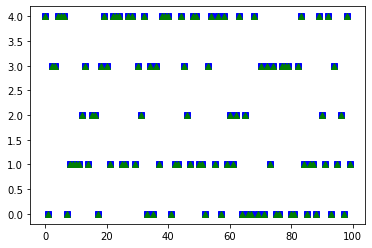

In [77]:
plt.plot(kmeans_iter1.labels_[900:1000],"yo", label="Cluster 1")
plt.plot(kmeans_iter1.labels_[900:1000],"bs", label="Cluster 2")
plt.plot(kmeans_iter1.labels_[900:1000],"g^", label="Cluster 3")

Lets see the perfomance by "inertia", higher is better

In [78]:
kmeans_iter1.inertia_

190757.83718583552

In [79]:
kmeans_iter2.inertia_

183353.4704994331

In [80]:
kmeans_iter3.inertia_

180424.46493226776

### Find the optimal number of clusters

now we increase the number ok clusters to find a "good" k

In [81]:
nk = 20
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, nk)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [82]:
inertias

[30486553.598772876,
 15615135.545590304,
 12073140.880083881,
 9877602.061445164,
 8693519.63006234,
 7925283.317268586,
 7317532.438624522,
 6824009.028019892,
 6537217.496653354,
 6159861.942236633,
 5888339.115160763,
 5508342.143204829,
 5326683.757747982,
 5111843.782741194,
 4975877.882998943,
 4756917.009761311,
 4604386.791869609,
 4435661.0420340905,
 4270889.049787506]

And do the elbow plot

Text(0, 0.5, 'Inertia')

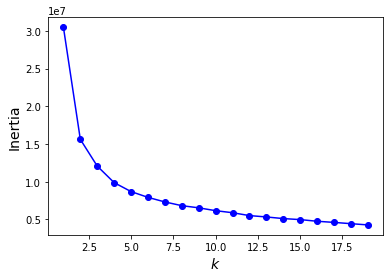

In [83]:
plt.plot(range(1, nk),inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

4 or 5 Clusters seem to be significant

### Hierarichal Clustering

Set up Hyrarchie plot

In [84]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

Check again Training set

In [87]:
X_train.head()

,age,gender,ap_hi,ap_lo,cholesterol,gluc,bmi
66590,-1.309825,1,-0.405771,-0.140358,0,2,1.203272
51432,-0.478279,1,0.805417,0.926138,2,2,-0.399091
8978,0.375971,0,2.924995,0.392890,2,2,4.837037
69162,1.291442,1,0.018145,-0.033708,2,2,2.047125
14788,0.931011,1,-0.405771,-0.140358,0,2,0.292821


Hierachical clustering is done with "AgglomerativeClustering" in sklearn 

In [86]:
# from sklearn.cluster import AgglomerativeClustering

# clustering = AgglomerativeClustering(linkage = 'ward', distance_threshold=0, n_clusters=None)
# model_cluster = clustering.fit(X_train)

# plot_dendrogram(model_cluster, truncate_mode="level", p=2)

Hyrarchie plot 

## Supervised Learning

- Linear Reg
- Logistic Reg
- Randforest
- ???

In [88]:
# Setup
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def plot_confusion_matrix(ytest = y_test, ypredtest = y_pred, method_title = None):
    matrix = confusion_matrix(ytest, ypredtest)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Build the plot
    
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, #, annot_kws={'size':10},
                cmap=plt.cm.Greens, linewidths=0.2)

    # Add labels to the plot
    class_names = ['Healthy', 'Sick']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks, class_names, rotation=25)
    plt.yticks(tick_marks2, class_names, rotation=0)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for {method_title} Model')

### Logistic Regression

A first attempt to predict cardio vascular disease is by using Logistic regression. Here, we apply the logistic regression with the 'liblinear' solver.

In [89]:
# Model creation & Fit
LogReg = LogisticRegression(solver='liblinear', random_state=42)
LogReg.fit(X_train, y_train)

LogisticRegression(random_state=42, solver='liblinear')

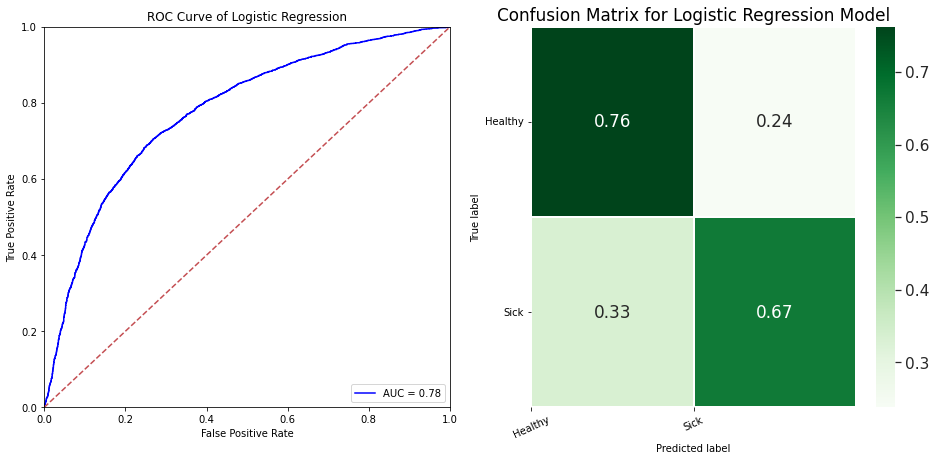

Model score on train data is 0.72
----------------------------------------
F1 score on test data is 0.7
Accuracy on test data is 0.72


In [90]:
score = LogReg.score(X_test, y_test)

y_pred = LogReg.predict(X_test)
y_scores = LogReg.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(16,7))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.subplot(1,2,2)
plot_confusion_matrix(y_test, y_pred, "Logistic Regression")
plt.show()

f1s = f1_score(y_test, y_pred)

print(f"Model score on train data is {np.round(LogReg.score(X_train, y_train), decimals=2)}")
print("----------------------------------------")
print(f"F1 score on test data is {np.round(f1s, decimals=2)}")
print(f'Accuracy on test data is {np.round(score, decimals=2)}')

Our model has a mean prediction accuracy of around 0.72, meaning that logistic regression was able to identify the label correctly in 72% of the cases.

### K-Nearest Neighbors

Another way to classify the data is to use k-nearest neighbor classifier.


In [91]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors = 5)
neigh.fit(X_train, y_train)

KNeighborsClassifier()

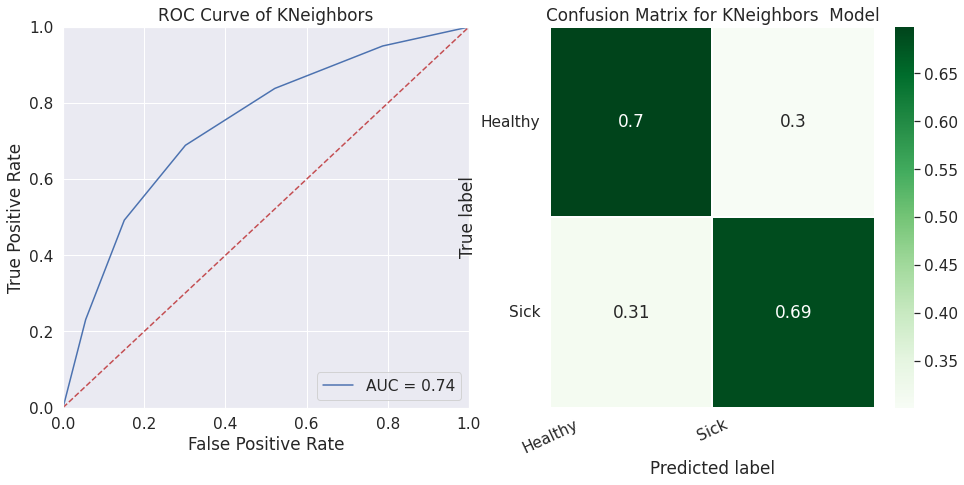

Model score on train data is 0.78
----------------------------------------
F1 score on test data is 0.69
Accuracy on test data is 0.69


In [92]:
score = neigh.score(X_test, y_test)

y_pred = neigh.predict(X_test)
y_scores = neigh.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(16,7))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of KNeighbors')
plt.subplot(1,2,2)
plot_confusion_matrix(y_test, y_pred, "KNeighbors ")
plt.show()

f1s = f1_score(y_test, y_pred)

print(f"Model score on train data is {np.round(neigh.score(X_train, y_train), decimals=2)}")
print("----------------------------------------")
print(f"F1 score on test data is {np.round(f1s, decimals=2)}")
print(f'Accuracy on test data is {np.round(score, decimals=2)}')

The model has a higher score than the logistic regression, however, it is comparable on the test data. It also indicates some overfitting.

### Support Vector machines

We attempt to classify the healthy versus sick people with support vector machines. We use the `LinearSVC` function with is similar to `SVC` with a linear `kernel`, but much faster.

In [93]:
from sklearn.svm import LinearSVC
svc = LinearSVC(max_iter=10000)
svc.fit(X_train, y_train)

LinearSVC(max_iter=10000)

In [94]:
score = svc.score(X_test, y_test)

y_pred = svc.predict(X_test)

f1s = f1_score(y_test, y_pred)

print(f"Model score on train data is {np.round(svc.score(X_train, y_train), decimals=2)}")
print("----------------------------------------")
print(f"F1 score on test data is {np.round(f1s, decimals=2)}")
print(f'Accuracy on test data is {np.round(score, decimals=2)}')

Model score on train data is 0.72
----------------------------------------
F1 score on test data is 0.69
Accuracy on test data is 0.71


Again, we obtain a very similar F1 score.

### Random Forest Classifier

We can also try to classify the data using ensemble methods. Here, we use the random forest algorithm.

In [96]:
from random import Random
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier()

Model score on train data is 1.0
----------------------------------------
Model score on test data is 0.7
Accuracy on test data is 0.71


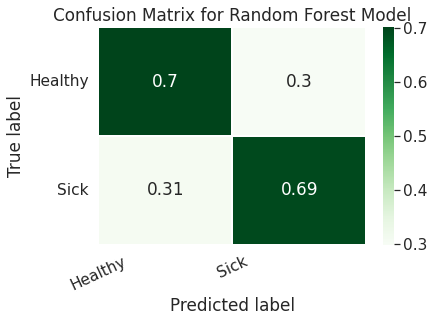

In [97]:
y_pred_test = forest.predict(X_test)
plot_confusion_matrix(y_test,y_pred_test, "Random Forest")
print(f"Model score on train data is {np.round(forest.score(X_train, y_train), decimals=2)}")
print("----------------------------------------")
print(f"Model score on test data is {np.round(forest.score(X_test, y_test), decimals=2)}")
print(f'Accuracy on test data is {np.round(score, decimals=2)}')

In [98]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.71      0.70      0.70      3572
           1       0.69      0.69      0.69      3426

    accuracy                           0.70      6998
   macro avg       0.70      0.70      0.70      6998
weighted avg       0.70      0.70      0.70      6998



A nice characteristic of random forest is that we can obtain the importance of individual features which allows to interpret the data more concretely.

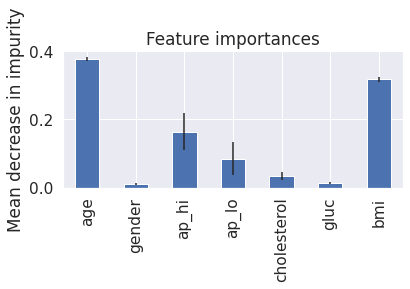

In [99]:
importances = forest.feature_importances_
feature_names = X_test.columns.values.tolist()
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

We see that the most important features are age and bmi.

## Deep Learning

- MLP
- Nural Net

In [100]:
import tensorflow as tf
from tensorflow import keras
%load_ext tensorboard

In [105]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[7]),
    keras.layers.Dense(28, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(28, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

model.summary()

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_test, y_test))


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 7)                 0         
                                                                 
 dense_12 (Dense)            (None, 28)                224       
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 28)                0         
                                                                 
 dense_13 (Dense)            (None, 28)                812       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 28)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 29        
                                                                 
Total params: 1,065
Trainable params: 1,065
Non-traina

/home/mk/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


1968/1968 [==============================] - 15s 7ms/step - loss: 0.6716 - accuracy: 0.6253 - val_loss: 0.5943 - val_accuracy: 0.7039
Epoch 2/10
1968/1968 [==============================] - 19s 10ms/step - loss: 0.5799 - accuracy: 0.7075 - val_loss: 0.5846 - val_accuracy: 0.7135
Epoch 3/10
1968/1968 [==============================] - 17s 8ms/step - loss: 0.5728 - accuracy: 0.7142 - val_loss: 0.5793 - val_accuracy: 0.7105
Epoch 4/10
1968/1968 [==============================] - 20s 10ms/step - loss: 0.5694 - accuracy: 0.7163 - val_loss: 0.5769 - val_accuracy: 0.7165
Epoch 5/10
1968/1968 [==============================] - 18s 9ms/step - loss: 0.5669 - accuracy: 0.7179 - val_loss: 0.5753 - val_accuracy: 0.7171
Epoch 6/10
1968/1968 [==============================] - 21s 10ms/step - loss: 0.5653 - accuracy: 0.7187 - val_loss: 0.5738 - val_accuracy: 0.7176
Epoch 7/10
1968/1968 [==============================] - 19s 10ms/step - loss: 0.5642 - accuracy: 0.7189 - val_loss: 0.5726 - val_accuracy:

### K Nearest neighbours

we know that the target labels are binary. So we set k for 2

In [86]:
k_range = list(range(1, 10))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test,y_test))

Text(0, 0.5, 'Accuracy')

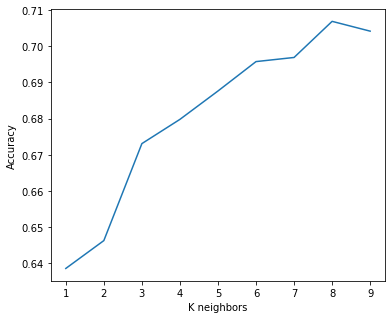

In [87]:
f, ax = plt.subplots(figsize = (6,5))
ax.plot(k_range, scores)
plt.xlabel('K neighbors')
plt.ylabel('Accuracy')